# Computational analysis to determine protein degradation motifs
Description

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from scipy import stats 
import sys
import sklearn
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import pylab as pl
from matplotlib import collections  as mc

In [2]:
sys.path.insert(0, '/Users/cynthiachen/Downloads/Internship2019/degron_mutation/deepDegron')
from train_nn import *

Using TensorFlow backend.


In [3]:
wd = '/Users/cynthiachen/Downloads/Internship2019/degron_mutation/'

In [4]:
# Load pre-trained neural network models from pickle file
model_bag_of_words = pickle.load(open( "../models/neural_network_bag_of_words_v2.pickle", "rb" ))
model_pos_specific = pickle.load(open( "../models/neural_network_pos_specific_v2.pickle", "rb" ))

# Create pd dataframe of sequence information 
degron_pred = pd.read_csv("../data/degron_pred.csv", index_col=0)
# Select column of input sequences
input_seq = degron_pred.iloc[:, 10]


# Use compute_feature_matrix function to encode sequences
features = compute_feature_matrix(input_seq, 6, True)
condensed_features = features[:, 0:20] # Remove zeros at the end for bag of words prediction

# Use pre-trained model to predict sequence degredataion
pred_bow_wt = model_bag_of_words.predict_proba(condensed_features) # wild-type bag of words prediction
pred_ps_wt = model_pos_specific.predict_proba(features)            # wild-type position-specific prediction
drp_wt = pred_ps_wt-pred_bow_wt                                    # wild-type degron regulatory potential

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [5]:
# Convert string to 2D list of characters

seqlist = [] # 2D list of all sequences, with each character as 1 entry 
for sequence in input_seq:
    seqlist.append(list(sequence))

In [6]:
# Define sequence information variables
seq_length = len(seqlist[0]) # 23
num_seq = len(seqlist)       # number of total sequences

In [7]:
# Sort degron sequence information by regulatory potential in descending order (highest to lowest)
degron_pred_sorted = degron_pred.sort_values(by=['regulatory potential'], ascending=False)

### 1. ROC curve calculation to statistically determine sequence cutoff

In [8]:
# Determines true labels based on bins
# Bins 1 & 2 -> 1 (high degradation)
# Bins 3 & 4 -> 0 (low degradation)

auc_info = np.asarray(degron_pred_sorted[['Modal Bin', 'sequence position specific', 'bag of words']])

for i in range(num_seq):
    mbin = auc_info[:, 0][i]
    if mbin > 2:
        auc_info[:, 0][i] = 0
    else:
        auc_info[:, 0][i] = 1

In [9]:
def auc_details(cutoff):
    y_true = auc_info[cutoff:num_seq-cutoff, 0]
    y_score_ss = auc_info[cutoff:num_seq-cutoff, 1] # Sequence-specific prediction scores
    y_score_bow = auc_info[cutoff:num_seq-cutoff, 2] # Bag of words prediction scores

    fp_ss, tp_ss, _ = sklearn.metrics.roc_curve(y_true, y_score_ss) # false-positive and true-positive
    auc_ss = auc(fp_ss, tp_ss)
    fp_bow, tp_bow, _ = sklearn.metrics.roc_curve(y_true, y_score_bow)
    auc_bow = auc(fp_bow, tp_bow) 
    
    return [fp_ss, tp_ss, auc_ss, fp_bow, tp_bow, auc_bow]

# cutoffs is a 1D list containing the cutoffs to be plotted
def plot_auc(cutoffs):
    colors = [ ['mediumpurple', 'indigo'], ['lightcoral', 'indianred'],
             ['cornflowerblue', 'mediumblue'], ['orange', 'darkorange'],['green', 'darkgreen']]
    #Accessed from: stackoverflow.com/questions/22408237/named-colors-in-matplotlib
    
    plt.figure()
    for i in range(len(cutoffs)): 
        c = cutoffs[i]
        a = auc_details(c)

        lw = 1.5
        plt.plot(a[0], a[1], color = colors[i][0],
                 lw = lw, label = 'Cutoff ' + str(c) + ', Sequence-specific (area = %0.3f)' % a[2])
        plt.plot(a[3], a[4], color = colors[i][1],
                 lw = lw, label = 'Cutoff ' + str(c) + ', Bag-of-words (area = %0.3f)' % a[5])
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC), Cutoff = ' + str(c))
    plt.legend(loc="lower right")
    
    cutoffs_str = [str(i) for i in cutoffs]
    cutoffs_file_name = '_'.join(cutoffs_str)
    plt.savefig(wd+'figures/cutoffs/auc/'+cutoffs_file_name,dpi=300)
    plt.close()

In [10]:
elbow = 1860

In [11]:
# Determine delta AUC values for all cutoffs to determine the minimum AUC

aucs = []
num_cutoffs = 400
increment = 20
cutoffs = np.asarray(range(num_cutoffs)) * increment

b=False
for c in cutoffs:
    a = auc_details(c)
    if (b==False and a[2] - a[5] < 0.01):
        print(c)
        b=True
    aucs.append(a[2] - a[5])
    
fig = plt.figure()
sns.set_style("darkgrid")
plt.plot(cutoffs, aucs)
plt.xlabel('Cutoff')
plt.ylabel('Delta AUC')

combined = np.asarray([cutoffs, aucs])
min_index = np.argmin(combined[1])
seq_cutoff = int(combined[0][min_index]) # cutoff for the minimum difference betweeen SS and BOW

# Points
plt.plot(seq_cutoff, combined[1][min_index], 'ro')
elbow_auc = auc_details(elbow)[2]-auc_details(elbow)[5]
plt.plot(elbow, elbow_auc, 'ro')

# Add annotation
ax = fig.add_subplot(111)
ax.annotate("Minimum \n (Cutoff = "+ str(seq_cutoff)+ ")", xy=(seq_cutoff, combined[1][min_index]), 
                  xytext=(seq_cutoff-2000, 0.025), #va="bottom", ha="center",
                  bbox=dict(boxstyle="round", fc="w"),
                  arrowprops=dict(arrowstyle="->"))
elbow = 1860
ax.annotate("Elbow \n (Cutoff = " + str(elbow) + ")", xy=(elbow, elbow_auc), 
                  xytext=(elbow, 0.025), #va="bottom", ha="center",
                  bbox=dict(boxstyle="round", fc="w"),
                  arrowprops=dict(arrowstyle="->"))
delta = u'Δ'
plt.title(delta + ' AUC at Various Cutoffs')
    
plt.savefig(wd+'figures/cutoffs/auc/delta_auc_over_cutoffs',dpi=300)
#plt.show()
plt.close()

1860


/Users/cynthiachen/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [12]:
seq_cutoff =1860

In [13]:
# Plot ROC curve for cutoff with minimum delta AUC in comparison to original AUC

plot_auc([0, int(seq_cutoff/2), seq_cutoff])
plot_auc([0, 2000])
plot_auc([0, seq_cutoff])
plot_auc([seq_cutoff])
plot_auc([0])

## 2. Motif Analysis
Discover patterns that characterize sequences with high & low degron regulatory potential

In [14]:
# Select only the "sequence" and "potential" columns and format values into a list
degron_seq_scores = degron_pred_sorted[['Peptide amino acid sequence','regulatory potential']].values.tolist()

In [15]:
# MOTIF ANALYSIS FUNCTIONS


# Function description: Determine the frequency of each kmer within the dataset
#
# Cutoff -- number of sequences from the top + bottom to consider for motif analysis
# kmer length -- length of kmers to be considered
# terminal -- how many amino acids to consider for each sequence (starting from the end)
#
# Returns a dictionary (key: kmer, value: frequency)

def kmer_freq(cutoff, kmer_length, terminal = seq_length):
    top = degron_seq_scores[0:cutoff]
    bottom = degron_seq_scores[-cutoff:]
    kmers = []
    kmer_dict = {}
    
    for row in top:
        sequence = row[0]
        for j in range(seq_length - terminal, seq_length - kmer_length + 1):
            kmers.append((sequence[j:(j + kmer_length)]+str(j+1), row[1])) 
            # add k-mer and corresponding score
    
    # Normalize drp scores to emphasize differences
    kmers = np.asarray(kmers) # Convert kmers to np array from a list
    x = np.asarray(list(map(float, kmers[:, 1])))
    normalized = (x-min(x))/(max(x)-min(x))
    kmers[:,1] = normalized
    
    # Convert list of kmers into 1 string
    kmer_str = " ".join(kmers[:, 0])
    kmer_list = list(kmers[:, 0])
    
    unique_kmers = [] 
  
    # Determine all unique kmers
    for i in kmer_list: 
        # checking for duplicacy 
        if i not in unique_kmers: 
            # insert value in str2 
            unique_kmers.append(i)  
    
    for i in range(0, len(unique_kmers)): 
        # count the frequency of each unique kmer and print 
        #print('Frequency of', unique_kmers[i], 'is :', kmer_list.count(unique_kmers[i]))
        kmer_dict.update({unique_kmers[i] : kmer_list.count(unique_kmers[i])})
    
    # Returns dictionary of [kmer sequence] -> [frequency]
    return kmer_dict


# Function description: Given a dataset of kmer information and a single specified kmer, 
# this function determines binomial probability values for various cutoffs 
# to determine the optimal motif cutoff frequency
# ???
def graph_binom(kmer, kmer_info):
    plt.close()
    # Retrieve kmer information from compiled dictionary
    info = kmer_info[kmer]
    top_count = info[2]
    baseline_prob = info[1] 
    p_value = info[3]
    
    # Determine frequency range to be plotted
    #middle = int(baseline_prob * seq_cutoff)
    middle = top_count
    freqs = range(middle - 20, middle + 20, 1)
    
    # Plot kmer-specific binomial curve
    binom_vals = []
    for i in freqs:
        binom_vals.append(stats.binom.sf(i, seq_cutoff, baseline_prob))
    
    fig = plt.figure()
    plt.plot(freqs, binom_vals, 'b', label = "Binomial expression")

    # Add annotations
    
    # horizontal ray
    plt.axhline(y=p_value, xmax=0.5, color='r', linestyle='--', label = "y = p-value", lw = 1)
    # vertical ray
    #plt.axvline(x=top_count, ymax=p_value, color='r', linestyle='--', label = "x = count", lw = 1)
    #plt.plot(pair_x, pair_y, 'm', linewidth=3)

    # based on top_freq
    ax = fig.add_subplot(111)

    plt.plot(top_count, p_value, 'ro') # point
    
    # plt.plot(motif_cutoff, binom_value, 'ro') #point
    # ax.annotate("Optimal Motif Frequency \n Cutoff = " + str(motif_cutoff), 
    # xy=(motif_cutoff, binom_value), 
    #                   xytext=(motif_cutoff-8, 0.4), #va="bottom", ha="center",
    #                   bbox=dict(boxstyle="round", fc="w"),
    #                   arrowprops=dict(arrowstyle="->"))

    plt.xlabel('Frequency Count')
    plt.ylabel('Binomial Survival Expression')
    plt.legend(loc="upper right")
    plt.title("Motif-Specific Binomial Survival Expression over Frequency Cutoffs: \n Motif = " + kmer)
    plt.savefig(wd+'figures/cutoffs/binomial/'+kmer,dpi=300)
    plt.close()
    

In [16]:
# gap is the position where the gap occurs
# Example: if AAA_A, then gap = 4
def kmer_freq_with_gap(cutoff, gap, kmer_length, terminal = seq_length):
    top = degron_seq_scores[0:cutoff]
    bottom = degron_seq_scores[-cutoff:]
    kmers = []
    kmer_dict = {}
    
    for row in top:
        sequence = row[0]
        for j in range(seq_length - terminal, seq_length - kmer_length + 1):
            kmer_str = sequence[j:(j+gap-1)] + '_' + sequence[(j+gap):(j+kmer_length)]
            kmers.append((kmer_str + str(j+1), row[1])) # add k-mer and corresponding score
    
    # Normalize drp scores to emphasize differences
    kmers = np.asarray(kmers) # Convert kmers to np array from a list
    x = np.asarray(list(map(float, kmers[:, 1])))
    normalized = (x-min(x))/(max(x)-min(x))
    kmers[:,1] = normalized
    
    # Convert list of kmers into 1 string
    kmer_str = " ".join(kmers[:, 0])
    kmer_list = list(kmers[:, 0])
    
    unique_kmers = [] 
  
    # Determine all unique kmers
    for i in kmer_list: 
        # checking for duplicacy 
        if i not in unique_kmers: 
            # insert value in str2 
            unique_kmers.append(i)  
    
    for i in range(0, len(unique_kmers)): 
        # count the frequency of each unique kmer and print 
        #print('Frequency of', unique_kmers[i], 'is :', kmer_list.count(unique_kmers[i]))
        kmer_dict.update({unique_kmers[i] : kmer_list.count(unique_kmers[i])})
    
    # Returns dictionary of [kmer sequence] -> [frequency]
    return kmer_dict

#### K-mer probability calculation to statistically determine significant motifs

In [30]:
seq_cutoff = 1860
kmer_length = 3
t = 6

# kmer_dict = kmer_freq_with_gap(cutoff = num_seq, gap=2, kmer_length = kmer_length, terminal = t) # not excluding any sequences
# kmer_dict_top = kmer_freq_with_gap(cutoff = seq_cutoff, gap=2, kmer_length = kmer_length, terminal = t)
kmer_dict = kmer_freq(cutoff = num_seq, kmer_length = kmer_length, terminal = t) # not excluding any sequences
kmer_dict_top = kmer_freq(cutoff = seq_cutoff, kmer_length = kmer_length, terminal = t)

# Create motif information dictionary:
# Key: kmer
# Values (kmer-specific):
# -- 1) total count (frequency of kmer among all sequences)
# -- 2) baseline probability, 
# -- 3) top count (frequency of kmer among "top" sequences as determined by seq_cutoff, 
# -- 4) p-value

kmer_info = {}

for kmer in kmer_dict_top:
    total_count = kmer_dict[kmer]
    baseline_prob = total_count / num_seq
    top_count = kmer_dict_top[kmer] # Frequency kmer among top sequences 
    p_value = stats.binom.sf(top_count - 1, seq_cutoff, baseline_prob) # Subtract 1 because of inclusitivity
    kmer_info.update({kmer : [total_count, baseline_prob, top_count, p_value]})              
                      

In [18]:
#graph_binom('EED18', kmer_info = kmer_info)

Benjamini Hochberg p-value adjustment

In [31]:
# Compile list of all p-values
p_values = []
for i in kmer_info:
    p_values.append(str(kmer_info[i][3]))
    
# Convert list of p-values to csv for R processing
pd.DataFrame(p_values).transpose().to_csv('p_values.csv', header=False, index=False)

In [117]:
# %run ./bh.ipynb

In [20]:
# AT THIS TIME: RUN bh.ipynb FILE

In [32]:
# Read in bh values from file
bh_p_values = pd.read_csv('bh_p_values.csv', header=None)[0]

# Add bh pvalues to kmer info table
counter = 0
for i in kmer_info:
    kmer_info[i].append(bh_p_values[counter])
    counter=counter+1

Determining top significant motifs

In [35]:
kmer_info_sorted = sorted(kmer_info.items(), key=lambda item: item[1][4])

i = 0
# Use BH p-values to determine significant motifs
while (kmer_info_sorted[i][1][4] <= 0.05):
    i=i+1
motif_cutoff = i
#length_significance.append(motif_cutoff) # for analysis on kmer length vs. # sig. motifs
    
top_motifs = kmer_info_sorted[0:motif_cutoff]
top_sequences = degron_seq_scores[0:seq_cutoff]

for i in range(motif_cutoff):
    top_motifs[i] = [top_motifs[i][0]]+top_motifs[i][1]
    
top_motifs = pd.DataFrame(top_motifs, columns = ['Motif', 'total count', 'baseline probability', 
                                    'top count', 'p-value', 'BH p-value'])

In [36]:
filename = 'motif_info/'+str(kmer_length)+'mers.csv'
pd.DataFrame(kmer_info_sorted).to_csv(filename, header=False, index=False)
filename = 'motif_info/'+str(kmer_length)+'mers_top.csv'
pd.DataFrame(top_motifs).to_csv(filename, header=False, index=False)

In [ ]:
# length_significance = pd.DataFrame([[2, 94], [3, 5], [4, 2], [5, 0], [6, 0]])

# # ax = sns.scatterplot(data = length_significance)
# # plt.show()

# length_significance.plot.scatter(x = 'Motif Length', y = 'Number of Significant Motifs')
# >>> df = pd.DataFrame([[2, 94, 0], [3, 5, 0], [4, 2, 0], 
#                        [5, 0, 0], [6, 0, 0]],
# ...                   columns=['length', 'sig', 'num'])
# >>> ax1 = df.plot.scatter(x='length',
# ...                       y='width',
# ...                       c='DarkBlue')
# plt.show()

## In-silico mutagenesis

In [55]:
# Determine motif and position index from the combined info
motif = top_motifs['Motif'][0][0:kmer_length]
index = int(top_motifs['Motif'][0][kmer_length:]) - 1

# Automated identification of sequences with highest DRP that contains the motif
for i in range(len(degron_seq_scores)):
    if degron_seq_scores[i][0].find(motif) == index:
        sequence = degron_seq_scores[i][0]
        original_drp = degron_seq_scores[i][1]
        break

In [108]:
# alphabet = []
# for letter in range(65, 91):
#     alphabet.append(chr(letter))
aa_list='ACDEFGHIKLMNPQRSTVWY'
aminoacids = []
for i in range(20):
    aminoacids.append(str(aa_list[i]))

In [109]:
mutated_drp = []
for i in range(kmer_length):
    position = index + i
    mutated_seq = []
    for letter in aminoacids:
        mutated_seq.append(sequence[:position] + letter + sequence[(position+1):])
    mutated_drp.append(get_drp(mutated_seq)[:, 0])

In [110]:
mutated_drp

[array([0.62800616, 0.6857218 , 0.6388301 , 0.5870752 , 0.6762639 ,
        0.6850141 , 0.63240063, 0.6310628 , 0.6318668 , 0.6965431 ,
        0.6724942 , 0.6446017 , 0.6423449 , 0.67316484, 0.6381016 ,
        0.6605034 , 0.65825725, 0.6672512 , 0.66837275, 0.6315276 ],
       dtype=float32),
 array([0.69362247, 0.69100857, 0.68812525, 0.6481874 , 0.69329584,
        0.6060663 , 0.6951194 , 0.69450855, 0.6363524 , 0.6945495 ,
        0.69589925, 0.62083626, 0.68928444, 0.6864103 , 0.6965431 ,
        0.6646352 , 0.69424564, 0.7003189 , 0.69272757, 0.6932513 ],
       dtype=float32),
 array([0.68459123, 0.6931365 , 0.67896676, 0.69103515, 0.6912949 ,
        0.69039387, 0.6626092 , 0.6951519 , 0.6851076 , 0.6925642 ,
        0.6970701 , 0.6832369 , 0.68262035, 0.66721094, 0.6965431 ,
        0.6845591 , 0.69003105, 0.69119406, 0.6813322 , 0.6693412 ],
       dtype=float32)]

In [113]:
def plot_weights(weights, plot_title, k):
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(weights, cmap='hot')

    # Set tick labels
    residues = list(range(1, k+1))
    ax.set_xticks(np.arange(len(residues)))
    ax.set_yticks(np.arange(len(aminoacids)))
    ax.set_xticklabels(residues)
    ax.set_yticklabels(aminoacids);

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    cbar = plt.colorbar(im)

    # Turn spines off and create white grid
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    ax.set_xticks(np.arange(weights.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(weights.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    # for tick in ax.xaxis.get_major_ticks():
    #     tick.label.set_fontsize(14) 
    # for tick in ax.yaxis.get_major_ticks():
    #     tick.label.set_fontsize(14) 

    # set size of tick labels
    plt.tick_params(axis='both', which='major', labelsize=18)
    cbar.ax.tick_params(labelsize=18) 
    
    # set title
    plt.title(plot_title, fontsize=20)
    
    from matplotlib import rcParams
    rcParams['axes.titlepad'] = 20 

#     plt.show()
    return fig

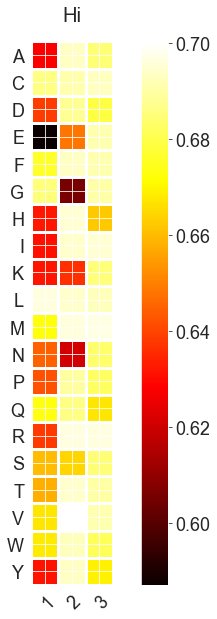

In [114]:
plot_weights(weights = np.transpose(np.asarray(mutated_drp)), plot_title = 'Hi', k = kmer_length)

In [59]:
# input_seq is a list of sequences to be inputted into deepDegron
def get_drp(input_seq):
    input_seq = pd.Series(input_seq)

    # Use compute_feature_matrix function to encode sequences
    features = compute_feature_matrix(input_seq, 6, True)
    condensed_features = features[:, 0:20] 
    # Remove zeros at the end for bag of words prediction

    # Use pre-trained model to predict sequence degredataion
    pred_bow = model_bag_of_words.predict_proba(condensed_features) 
    pred_ps = model_pos_specific.predict_proba(features)
    drp = pred_ps-pred_bow
    return drp

In [58]:
drp_wt

array([[0.696543]], dtype=float32)

Position analysis

In [ ]:
positions = []
for row in top_motifs:
    kmer = row[0]
    #positions = {}
    positions_one_kmer = []
    for seq in top_sequences:
        location = seq[0].find(kmer)
        if location > -1:  # if kmer exists in sequence
            #positions.update({location : positions[location]+1})
            positions_one_kmer.append(location)
    positions.append(positions_one_kmer)

In [ ]:
positions[0]

In [ ]:
plt.close()
sns.distplot(positions[0])
plt.title("Position Frequency, Motif = CGC")
plt.savefig(wd+'figures/motifs/CGC',dpi=300)

In [ ]:
positions[0]

In [ ]:
top_motifs

In [ ]:
kmer_info_sorted[0][1][3]

Old code

In [ ]:
# Calculate baseline frequency by averaging frequencies
# How likely a kmer is to appear at random 

# freq_sum = 0
# for i in kmer_dict:
#     freq_sum += kmer_dict[i]
# baseline = freq_sum / (num_seq * len(kmer_dict))

# GENERAL / AVERAGE
# Determine motif cutoff using Binomial expression and baseline

# i = 0
# while stats.binom.sf(i, seq_cutoff, baseline) > 0.05:
#     i = i+1
# motif_cutoff = i
# binom_value = stats.binom.sf(i, seq_cutoff, baseline)

# def binomcdf_orig():
#     #p = baseline
#     p = baseline_prob
#     n = seq_cutoff
#     x = 100
#     result = []
#     labels = []
#     for a in range(20):
#         labels.append(x)
#         result.append(stats.binom.sf(x, n, p))
#         x += 5
#     return result, labels

# # plt.hist(binomcdf())
# # plt.show()
# b, l = binomcdf()

In [ ]:
# # Calculates motif-specific p-value
# # Lower p-value = higher enrichment of kmer among top sequences
# def p_value(kmer):
#     baseline_prob = kmer_dict[kmer] / num_seq
    
#     # Frequency kmer among top sequences
#     top_freq = kmer_dict_top[kmer] 
    
#     return stats.binom.sf(top_freq, seq_cutoff, baseline_prob)

In [ ]:
#     lines = [[(middle - 100, p_value), (top_count, p_value)], 
#              [(top_count, -0.05), (top_count, p_value)]]
#     c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])

#     lc = mc.LineCollection(lines, colors=c, linewidths=2)
#     fig, ax = pl.subplots()
#     ax.add_collection(lc)
#     ax.autoscale()
#     ax.margins(0.1)

Seaborn stuff

In [ ]:
sns.set(style="ticks")

rs = np.random.RandomState(11)
x = rs.gamma(2, size=1000)
y = -.5 * x + rs.normal(size=1000)

sns.jointplot(x, y, kind="hex", color="#4CB391")

In [ ]:
plt.show()

In [ ]:
# p_vals

In [ ]:
# Load the example flights dataset and conver to long-form
flights_long = sns.load_dataset("flights")
flights = flights_long.pivot("month", "year", "passengers")

In [ ]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(flights, annot=True, fmt="d", linewidths=.5, ax=ax)

In [ ]:
plt.show()

Motif analysis with DRP score weighting

In [ ]:
# Function description: 
#
# Cutoff -- number of sequences from the top + bottom to consider for motif analysis
# Motif length -- length of kmer motifs to be considered

def motif_with_weighting(cutoff = 50, motif_length = 2):
    top = degron_seq_scores[0:cutoff]
    bottom = degron_seq_scores[-cutoff:]
    kmers = []
    
    for row in top:
        sequence = row[0]
        for j in range(seq_length - motif_length + 1):
            kmers.append((sequence[j:(j+motif_length)], row[1])) # add k-mer and corresponding score
    
    # Normalize drp scores to emphasize differences
    kmers = np.asarray(kmers) # Convert kmers to np array from a list
    x = np.asarray(list(map(float, kmers[:, 1])))
    normalized = (x-min(x))/(max(x)-min(x))
    kmers[:,1] = normalized
    
    # Convert list of kmers into 1 string
    kmer_str = " ".join(kmers[:, 0])
    kmer_list = list(kmers[:, 0])
    
    unique_kmers = [] 
  
    # Determine all unique kmers
    for i in kmer_list: 
        # checking for duplicacy 
        if i not in unique_kmers: 
            # insert value in str2 
            unique_kmers.append(i)  
    
    for i in range(0, len(unique_kmers)): 
        # 
        np.asarrray
        kmer_dict.update({unique_kmers[i] : kmer_list.count(unique_kmers[i])})